- mamba install optuna 
- pip install optuna-integration[lightgbm]

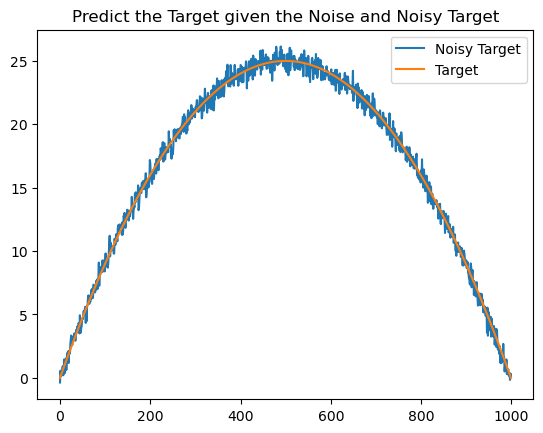

In [ ]:
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import shap
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

rng = np.random.default_rng(seed=42)
num_rows = 1_000

binary = rng.binomial(n=1, p=0.5, size=num_rows)

line = np.linspace(0, 10, num_rows)
noise = rng.normal(loc=0, scale=.5, size=num_rows)
target = 10*line - line**2
noisy_target = target + noise 

df = pd.DataFrame({
    'line': line,
    'noise': noise,
    'target': target,
    'noisy_target': noisy_target,
})

sns.lineplot(noisy_target, label='Noisy Target')
sns.lineplot(target, label='Target')

plt.title("Predict the Target given the Noise and Noisy Target")
plt.legend()
plt.show()

X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns='target'), target, test_size=0.2, random_state=42)

## Optuna 
Sampling types:
* Categorical: `trial.suggest_categorical("optimizer", ["MomentumSGD", "Adam"])`
* Integer: `trial.suggest_int("num_layers", 32, 512)`
* Float: `trial.suggest_float("dropout_rate", 0.0, 1.0)`

Parameters:
* Step: `trial.suggest_int("num_layers", 32, 512, log=True)`
* Log: `trial.suggest_int("num_layers", 32, 512, step=5)`

In [70]:
def objective(trial):    
    # Define the hyperparameter search space
    param = {
        'random_state': 42,
        'early_stopping_rounds': 50, # the {n}th accuracy on the validation set does not improve, stop training
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',
        'force_row_wise': True, # Runs faster if you have enough memory

        # bagging_fraction is like feature_fraction, but randomly selects data without resampling
        # bagging_freq must be non-zero to enable bagging
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # default = 10.0,  used for the categorical features
        'cat_l2':  trial.suggest_float('cat_l2', 0.01, 20),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # colsample_bytree is ignored when feature_fraction is set
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),

        # max number of bins that feature values will be bucketed in
        'max_bin': trial.suggest_int('max_bin', 2, 1000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 1000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf ', 5, 100),
        'min_split_gain': 0.5,
        
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),

        'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    model = lgb.train(
        params=param,
        train_set=train_data,
        valid_sets=[valid_data],
        valid_names=['valid'],
        # NOTE: to monitor overfitting, track both:
        # valid_sets=[train_data, valid_data],
        # valid_names=['train', 'valid'],
        callbacks=[
            LightGBMPruningCallback(trial, "rmse", valid_name="valid"),
            lgb.log_evaluation(-1) # Suppress training logs
        ]
    )
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))    
    return rmse


model_str = "lgb_"
study_name = 'simple_example_'
study = optuna.create_study(
        # storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        # study_name=model_str + study_name + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=50)
print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["metric"] = "rmse"
best_params["force_row_wise"] = True

[I 2025-02-18 08:36:31,676] A new study created in memory with name: no-name-36884a12-973a-4a12-87c7-d38dc689dd8e
[I 2025-02-18 08:36:32,551] Trial 0 finished with value: 0.532120653218579 and parameters: {'bagging_fraction': 0.6991825278248776, 'bagging_freq': 3, 'cat_l2': 0.7171081025943271, 'extra_trees': False, 'feature_fraction': 0.4215103694094321, 'learning_rate': 0.015805969749944748, 'max_bin': 492, 'max_depth': 617, 'min_samples_leaf ': 61, 'n_estimators': 520, 'num_leaves': 10, 'lambda_l1': 0.001730535552288783, 'lambda_l2': 4.714076921329956e-05, 'subsample': 0.2270995159013765}. Best is trial 0 with value: 0.532120653218579.
[I 2025-02-18 08:36:32,624] Trial 1 finished with value: 2.5865119333835818 and parameters: {'bagging_fraction': 0.495782176763923, 'bagging_freq': 4, 'cat_l2': 13.853504749896578, 'extra_trees': True, 'feature_fraction': 0.5544721403655563, 'learning_rate': 0.028632664239676427, 'max_bin': 246, 'max_depth': 805, 'min_samples_leaf ': 88, 'n_estimators'


Number of finished trials: 50
Best trial: 23
Best value (RMSE): 0.20739922956290496
Best hyperparameters: {'bagging_fraction': 0.7562971742206365, 'bagging_freq': 5, 'cat_l2': 16.758055756162033, 'extra_trees': False, 'feature_fraction': 0.6123378688624005, 'learning_rate': 0.04273221714241378, 'max_bin': 317, 'max_depth': 894, 'min_samples_leaf ': 14, 'n_estimators': 983, 'num_leaves': 198, 'lambda_l1': 3.763778890178454e-07, 'lambda_l2': 0.0027904010880462396, 'subsample': 0.2093213010005615}


In [71]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
model = lgb.train(
    params=study.best_params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train_0', 'valid_0'],
)
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

<Axes: xlabel='line'>

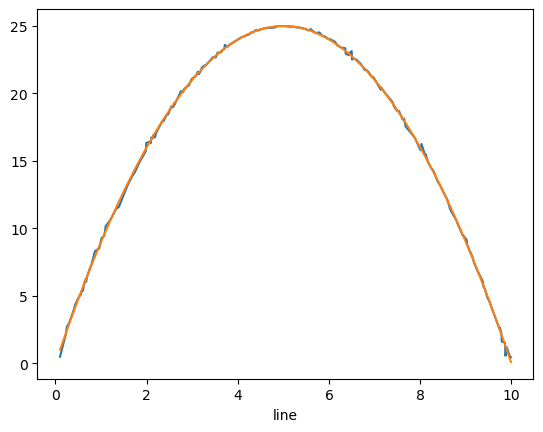

In [72]:
sns.lineplot(x=X_valid.loc[:, "line"], y=y_pred)
sns.lineplot(x=X_valid.loc[:, "line"], y=y_valid)

### [plot_importance](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html)

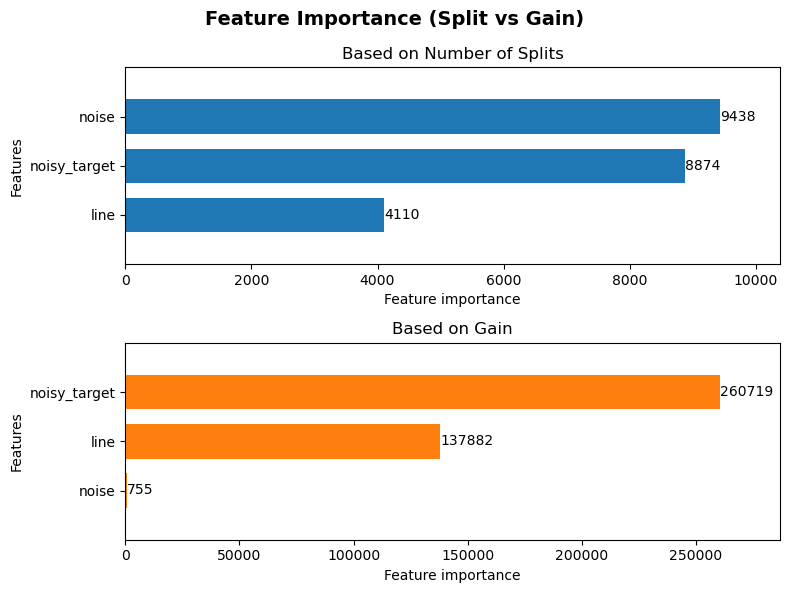

In [73]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

fig.suptitle("Feature Importance (Split vs Gain)", fontsize=14, fontweight='bold')

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)


plt.tight_layout()
plt.show()

## Shap

In [74]:
shap.initjs()

In [75]:
feature_names = X_valid.columns.to_list()

In [76]:
explainer = shap.TreeExplainer(model, feature_names=feature_names)
explanation = explainer(X_valid)
shap_values = explanation.values

Feature Importance

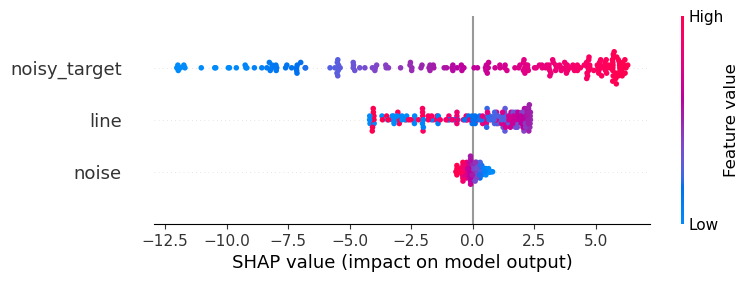

In [77]:
shap.plots.beeswarm(explanation)

Invidiual prediction

line             5.215215
noise            0.164184
noisy_target    25.117866
Name: 521, dtype: float64

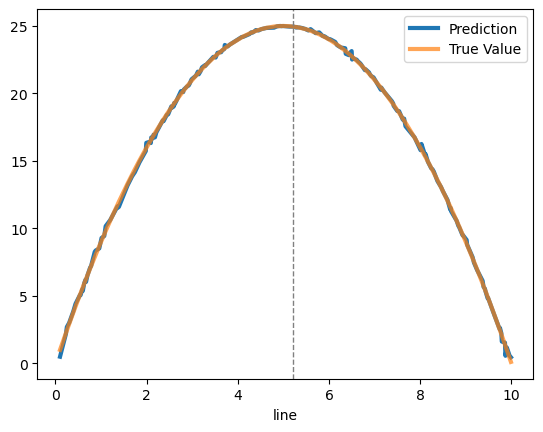

In [115]:
i = 0
sample = X_valid.iloc[i]
display(sample)
sns.lineplot(x=X_valid.loc[:, "line"], y=y_pred, label="Prediction", linewidth=3)
sns.lineplot(x=X_valid.loc[:, "line"], y=y_valid, label="True Value", alpha=.7, linewidth=3)
plt.axvline(x=sample['line'], color='gray', linestyle='--', linewidth=1)
plt.show()

force_plot = shap.force_plot(explainer.expected_value, shap_values[i,:], feature_names=feature_names)
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

line             2.962963
noise           -0.223579
noisy_target    20.626901
Name: 296, dtype: float64

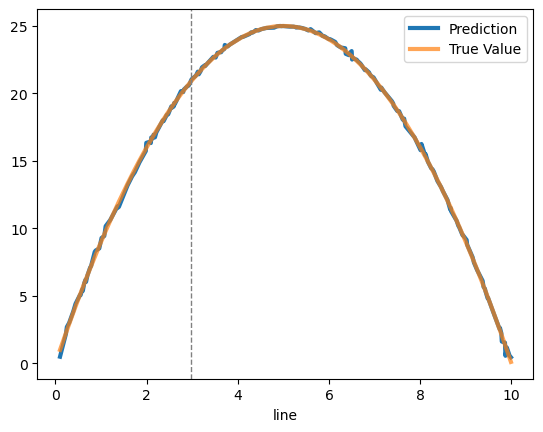

In [114]:
i = 60
sample = X_valid.iloc[i]
display(sample)
sns.lineplot(x=X_valid.loc[:, "line"], y=y_pred, label="Prediction", linewidth=3)
sns.lineplot(x=X_valid.loc[:, "line"], y=y_valid, label="True Value", alpha=.7, linewidth=3)
plt.axvline(x=sample['line'], color='gray', linestyle='--', linewidth=1)
plt.show()

force_plot = shap.force_plot(explainer.expected_value, shap_values[i,:], feature_names=feature_names)
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

All predictions

In [79]:
force_plot = shap.plots.force(explainer.expected_value, shap_values, feature_names=feature_names)

HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

In [ ]:
shap.dependence_plot("line", shap_values.values, X_valid, interaction_index="noisy_target")

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [116]:
feature_names

['line', 'noise', 'noisy_target']

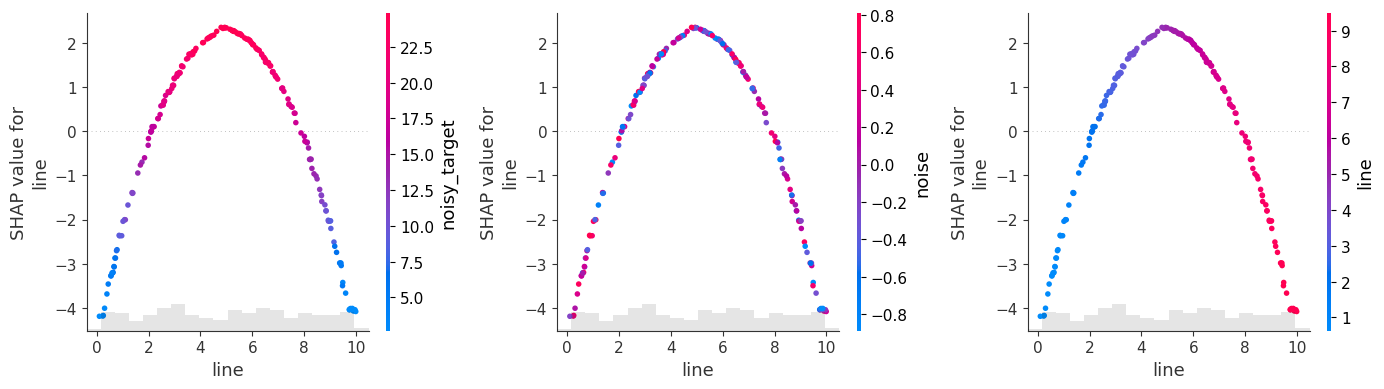

In [135]:
col = "line"
inds = shap.utils.potential_interactions(explanation[:, col], explanation)

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for i in range(3):
    shap.plots.scatter(explanation[:, col], color=explanation[:, inds[i]], ax=axs[i], show=False)

plt.tight_layout()
plt.show()

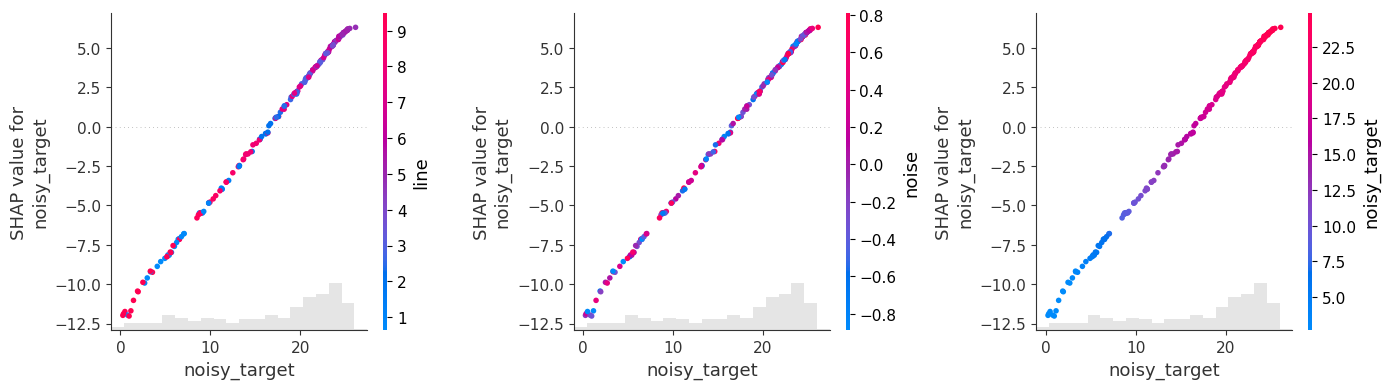

In [136]:
col = "noisy_target"
inds = shap.utils.potential_interactions(explanation[:, col], explanation)

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for i in range(3):
    shap.plots.scatter(explanation[:, col], color=explanation[:, inds[i]], ax=axs[i], show=False)

plt.tight_layout()
plt.show()

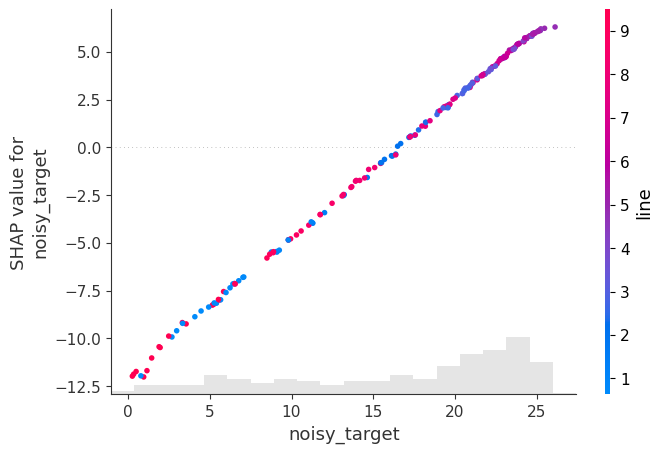

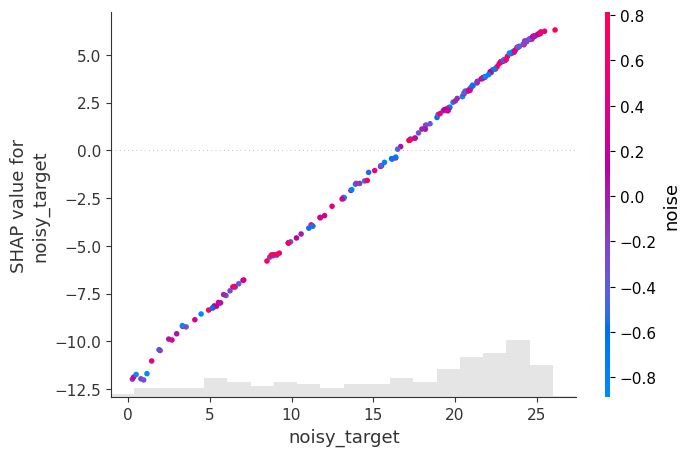

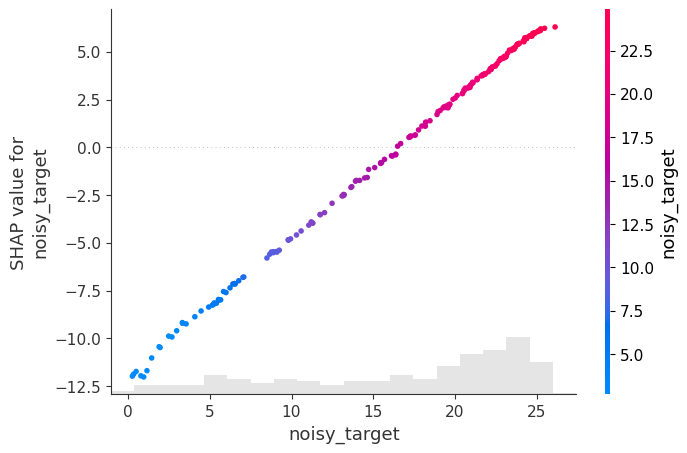

In [121]:
col = "noisy_target"
inds = shap.utils.potential_interactions(explanation[:, col], explanation)

for i in range(3):
    shap.plots.scatter(explanation[:, col], color=explanation[:, inds[i]])

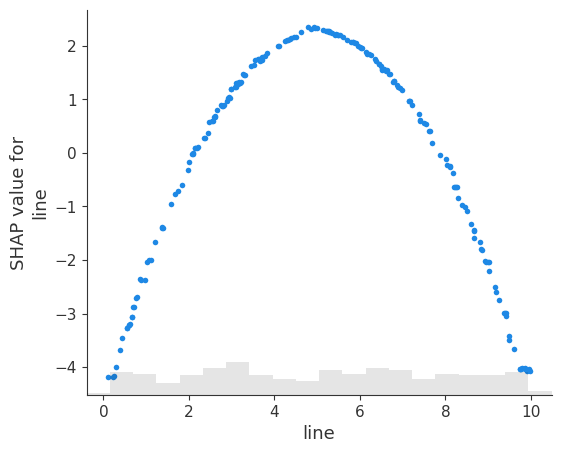

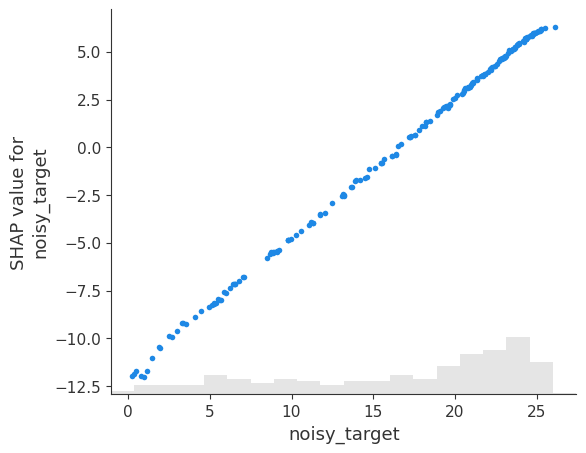

In [126]:
shap.plots.scatter(explanation[:, "line"])
shap.plots.scatter(explanation[:, "noisy_target"])